In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error
from math import sqrt
from foursquareAPI import get_poi

In [5]:
df = pd.read_csv("Parkirisca_do_10_05_2022.csv")
df["Zasedenost"] = df["Kapaciteta"] - df["Prosta mesta"]
df['date'] = pd.to_datetime(df["Datum"], unit="s")
df = df.drop(["Datum", "Prosta (narocniki)", "Oddana (narocniki)",
             "Na voljo (narocniki)", "Cakalna vrsta (narocniki)"], axis=1)
df

,Parkirisce,Prosta mesta,Kapaciteta,Zasedenost,date
0,Bezigrad,58,64,6,2022-02-24 19:13:21
1,Center Stozice,142,509,367,2022-02-24 19:13:21
2,Dolenjska cesta (Strelisce),50,67,17,2022-02-24 19:13:21
3,Gosarjeva ulica,16,190,174,2022-02-24 19:13:21
4,Gosarjeva ulica II.,121,115,-6,2022-02-24 19:13:21
...,...,...,...,...,...
292887,SRC Stozice,0,0,0,2022-05-10 06:05:38
292888,Tacen,0,0,0,2022-05-10 06:05:38
292889,Bratislavska,0,0,0,2022-05-10 06:05:38
292890,BS4/ I,63,80,17,2022-05-10 06:05:38


In [6]:
def copy_and_impute(parking):
    # Prepare new data frame, which will be synced (freqeuncy is exactly 10 mins)
    parking_sync = parking.asfreq("10 min")

    # Copy data before hole 1
    hole_start_date1 = pd.to_datetime("2022-03-15 08:25:12", format='%Y-%m-%d %H:%M:%S')
    for ((index, row), (index_sync, row_sync)) in zip(parking.iterrows(), parking_sync.iterrows()):
        if index > hole_start_date1:
            break
        row_sync["Zasedenost"] = row["Zasedenost"]

    # Impute first hole
    hole_end_date1 = pd.to_datetime("2022-03-23 07:02:59", format='%Y-%m-%d %H:%M:%S')
    num_rows_imputed = 0
    for index_sync, row_sync in parking_sync.iterrows():
        if index_sync <= hole_start_date1:
            continue
        if index_sync >= hole_end_date1:
            break
        # Repeat data from previous week day
        row_sync["Zasedenost"] = parking_sync[parking_sync.index ==
                                              index_sync - pd.to_timedelta(1, unit="W")]["Zasedenost"][0]
        num_rows_imputed += 1

    # Copy data after hole 1, before hole 2
    hole_start_date2 = pd.to_datetime("2022-04-07 22:10:55", format='%Y-%m-%d %H:%M:%S')
    for ((index, row), (index_sync, row_sync)) in zip(parking.iterrows(), parking_sync.iloc[num_rows_imputed:].iterrows()):
        if index < hole_end_date1:
            continue
        if index >= hole_start_date2:
            break
        row_sync["Zasedenost"] = row["Zasedenost"]

    # Impute second hole
    hole_end_date2 = pd.to_datetime("2022-04-22 08:11:54", format='%Y-%m-%d %H:%M:%S')
    for index_sync, row_sync in parking_sync.iterrows():
        if index_sync <= hole_start_date2:
            continue
        if index_sync > hole_end_date2:
            break
        # Repeat data from previous week day
        row_sync["Zasedenost"] = parking_sync[parking_sync.index ==
                                              index_sync - pd.to_timedelta(1, unit="W")]["Zasedenost"][0]
        num_rows_imputed += 1

    # Copy the remaning data
    hole_start_date2 = pd.to_datetime("2022-04-07 22:10:55", format='%Y-%m-%d %H:%M:%S')
    for ((index, row), (index_sync, row_sync)) in zip(parking.iterrows(), parking_sync.iloc[num_rows_imputed:].iterrows()):
        if index < hole_end_date2:
            continue
        row_sync["Zasedenost"] = row["Zasedenost"]

    parking_sync = parking_sync["Zasedenost"].fillna(method="bfill")  # Fill remaning spaces with previous values
    parking_sync.dropna(axis=0, inplace=True)  # Remove the somehow remaning NaN rows

    return parking_sync

In [7]:
parkings = {}
for name, group in df.groupby("Parkirisce"):
    name = str(name)
    parking = group

    parking = parking.set_index('date')
    parking = parking.drop(["Parkirisce", "Prosta mesta"], axis=1)

    capacity = 0
    for _, row in parking.iterrows():
        if row["Kapaciteta"] != 0:
            capacity = row["Kapaciteta"]
            break

    raidus = 50
    points_of_interest = get_poi(name, radius=raidus)

    # Filter empty data (10 parkings)
    if (parking["Zasedenost"] == 0).all() or (parking["Zasedenost"] == capacity).all() or points_of_interest is None:
        continue

    parking_sync = pd.DataFrame(copy_and_impute(parking))
    parking_sync["Kapaciteta"] = [capacity for _ in range(len(parking_sync.index))]
    parking_sync["Procent_zasedenosti"] = parking_sync["Zasedenost"] / parking_sync["Kapaciteta"]

    # Add points of interest to the specific column (0: not present, radius-distance: point of interest score) -> POIs are weighted
    restaurant_dist = []
    art_dist = []
    coffee_dist = []
    bar_dist = []
    for distance, poi in points_of_interest:
        if "Restaurant" in poi:
            restaurant_dist.append(distance)
        elif "Art" in poi or "Museum" in poi:
            art_dist.append(distance)
        elif "Coffee" in poi or "Café" in poi or "Cafeteria" in poi:
            coffee_dist.append(distance)
        elif "Bar" in poi:
            bar_dist.append(distance)
    
    restaurant_score = 0 if not restaurant_dist else raidus + 1 - sum(restaurant_dist) / len(restaurant_dist)
    art_score = 0 if not art_dist else raidus + 1 - sum(art_dist) / len(art_dist)
    coffee_score = 0 if not coffee_dist else raidus + 1 - sum(coffee_dist) / len(coffee_dist)
    bar_score = 0 if not bar_dist else raidus + 1 - sum(bar_dist) / len(bar_dist)
    
    parking_sync["Restaurant_score"] = [restaurant_score for _ in range(len(parking_sync.index))]
    parking_sync["Art_score"] = [art_score for _ in range(len(parking_sync.index))]
    parking_sync["Coffee_score"] = [coffee_score for _ in range(len(parking_sync.index))]
    parking_sync["Bar_score"] = [bar_score for _ in range(len(parking_sync.index))]

    parking_sync = parking_sync.astype({"Zasedenost": int, "Kapaciteta": int, "Procent_zasedenosti": float,
                                               "Restaurant_score": float,	"Art_score": float,	"Coffee_score": float,	"Bar_score": float})

    parkings[name] = parking_sync  # Save the synced data frame to dict

print(parkings)

{'BS4/ I':                      Zasedenost  Kapaciteta  Procent_zasedenosti  \
date                                                               
2022-03-04 09:31:53           0          80               0.0000   
2022-03-04 09:41:53           0          80               0.0000   
2022-03-04 09:51:53           0          80               0.0000   
2022-03-04 10:01:53           0          80               0.0000   
2022-03-04 10:11:53           0          80               0.0000   
...                         ...         ...                  ...   
2022-05-10 03:51:53          17          80               0.2125   
2022-05-10 04:01:53          16          80               0.2000   
2022-05-10 04:11:53          15          80               0.1875   
2022-05-10 04:21:53          16          80               0.2000   
2022-05-10 04:31:53          17          80               0.2125   

                     Restaurant_score  Art_score  Coffee_score  Bar_score  
date                        

In [85]:
parkings.keys()

dict_keys(['BS4/ I', 'BS4/ II', 'Bezigrad', 'Dolenjska cesta (Strelisce)', 'Gosarjeva ulica', 'Gosarjeva ulica II.', 'Gospodarsko razstavisce', 'Kozolec', 'Kranjceva ulica', 'Linhartova', 'Metelkova ulica', 'Mirje', 'NUK II.', 'PH Kolezija', 'PH Kongresni trg', 'Petkovskovo nabrezje II.', 'Pokopalisce Polje', 'Povsetova ulica', 'Senatorij Emona', 'Slovenceva ulica', 'Tivoli I.', 'Tivoli II.', 'Trg mladinskih delovnih brigad', 'Trg prekomorskih brigad', 'Zale I.', 'Zale II.', 'Zale III.', 'Zale IV.', 'Zale V.'])

In [86]:
curr_df = parkings["Bezigrad"][["Zasedenost"]]
curr_df

,Zasedenost
date,
2022-02-24 19:13:21,6
2022-02-24 19:23:21,5
2022-02-24 19:33:21,5
2022-02-24 19:43:21,6
2022-02-24 19:53:21,5
...,...
2022-05-10 04:33:21,10
2022-05-10 04:43:21,11
2022-05-10 04:53:21,13


<AxesSubplot:xlabel='date'>

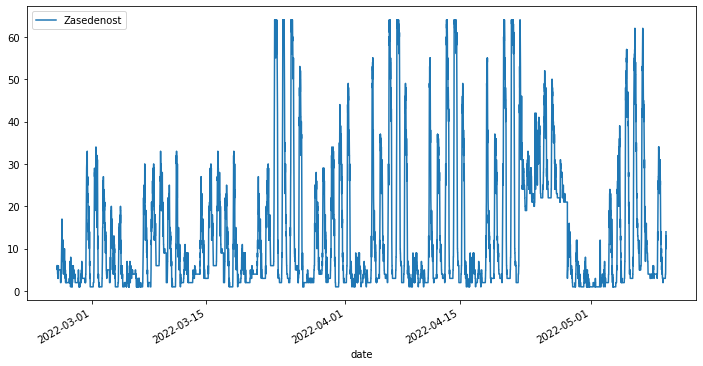

In [97]:
curr_df.plot(figsize=(12,6))

In [98]:
curr_df.head()

,Zasedenost
date,
2022-02-24 19:13:21,6
2022-02-24 19:23:21,5
2022-02-24 19:33:21,5
2022-02-24 19:43:21,6
2022-02-24 19:53:21,5


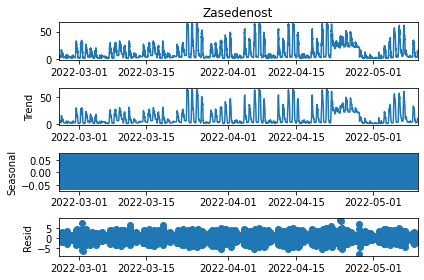

In [99]:
decompfreq = 1 * 60 // 10 # seasonality: 1/h, frequency: 10 min
results = seasonal_decompose(curr_df['Zasedenost'],period=decompfreq)
results.plot();

In [100]:
len(curr_df)

10717

In [116]:
train_size = int(len(curr_df) * 0.75)
train = curr_df.iloc[:train_size]
test = curr_df.iloc[train_size:]

In [117]:
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [118]:
scaled_train[:10]

array([[0.07936508],
       [0.06349206],
       [0.06349206],
       [0.07936508],
       [0.06349206],
       [0.06349206],
       [0.04761905],
       [0.04761905],
       [0.04761905],
       [0.04761905]])

In [131]:
# define generator
n_input = 6
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [132]:
X, y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.07936508 0.06349206 0.06349206 0.07936508 0.06349206 0.06349206]
Predict this y: 
 [[0.04761905]]


In [133]:
X.shape

(1, 6, 1)

In [134]:
# define model
model = Sequential()
model.add(LSTM(100, input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [135]:
# fit model
model.fit(generator,epochs=10)

Epoch 1/10
8031/8031 [==============================] - 35s 4ms/step - loss: 0.0018
Epoch 2/10
8031/8031 [==============================] - 36s 5ms/step - loss: 8.4867e-04
Epoch 3/10
8031/8031 [==============================] - 36s 5ms/step - loss: 8.0850e-04
Epoch 4/10
8031/8031 [==============================] - 37s 5ms/step - loss: 7.7085e-04
Epoch 5/10
8031/8031 [==============================] - 36s 5ms/step - loss: 7.6212e-04
Epoch 6/10
8031/8031 [==============================] - 36s 5ms/step - loss: 7.4913e-04
Epoch 7/10
8031/8031 [==============================] - 37s 5ms/step - loss: 7.4382e-04
Epoch 8/10
8031/8031 [==============================] - 37s 5ms/step - loss: 7.3324e-04
Epoch 9/10
8031/8031 [==============================] - 36s 5ms/step - loss: 7.2522e-04
Epoch 10/10
8031/8031 [==============================] - 36s 4ms/step - loss: 7.3289e-04


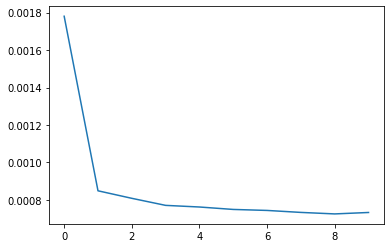

In [136]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [137]:
test_predictions = []
first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))
for i in range(len(test)):
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    # append the prediction into the array
    test_predictions.append(current_pred) 
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [138]:
test_predictions

[array([0.8834384], dtype=float32),
 array([0.85934204], dtype=float32),
 array([0.8328882], dtype=float32),
 array([0.8053166], dtype=float32),
 array([0.776497], dtype=float32),
 array([0.74588186], dtype=float32),
 array([0.71339047], dtype=float32),
 array([0.67882895], dtype=float32),
 array([0.6420125], dtype=float32),
 array([0.602865], dtype=float32),
 array([0.5614486], dtype=float32),
 array([0.51800835], dtype=float32),
 array([0.4730334], dtype=float32),
 array([0.4272837], dtype=float32),
 array([0.38176784], dtype=float32),
 array([0.33765492], dtype=float32),
 array([0.29612082], dtype=float32),
 array([0.2581652], dtype=float32),
 array([0.22445981], dtype=float32),
 array([0.19528039], dtype=float32),
 array([0.17053415], dtype=float32),
 array([0.14985274], dtype=float32),
 array([0.13270548], dtype=float32),
 array([0.11850036], dtype=float32),
 array([0.10665869], dtype=float32),
 array([0.09666138], dtype=float32),
 array([0.08807079], dtype=float32),
 array([0.080

In [139]:
true_predictions = scaler.inverse_transform(test_predictions)

In [140]:
test['Predictions'] = true_predictions

C:\Users\Matija\AppData\Local\Temp\ipykernel_12804\4269337381.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


<AxesSubplot:xlabel='date'>

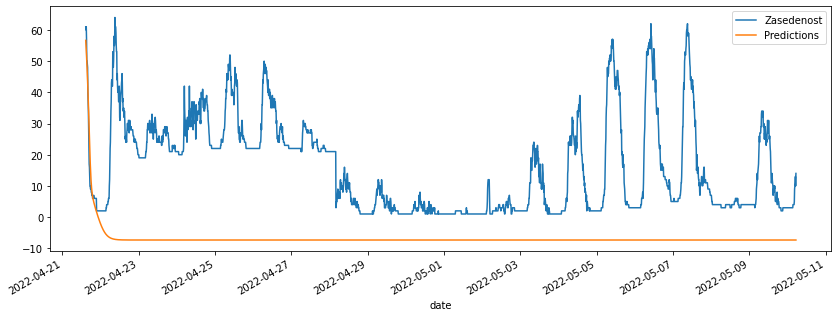

In [141]:
test.plot(figsize=(14,5))

In [142]:
rmse = sqrt(mean_squared_error(test['Zasedenost'], test['Predictions']))
print(rmse)


27.26019049128923
